In [ ]:
%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("jpg"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

5243


In [ ]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(195, 240)


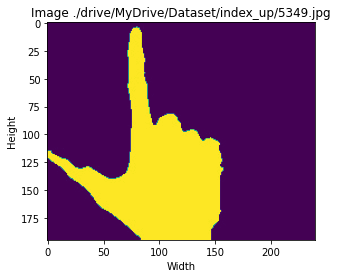

In [ ]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [ ]:
print(len(imagepaths))

5243


In [ ]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  #img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  img = cv2.resize(img, (227,681)) # Reduce image size so training can be faster
  X.append(img)
  # Processing label in image path

  # print(path)
  label = path.split("/")[4]
  #label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  #print(path)
  y.append(label)

print(len(X))


print(len(imagepaths))
print(X[0].shape)

print("done")

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 160, 80, 3) # Needed to reshape so CNN knows it's different images
X = X.reshape(len(imagepaths), 227, 227, 3) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))
print(y[0], imagepaths[0]) # Debugging

5243
5243
(681, 227)
done
Images loaded:  5243
Labels loaded:  5243
index_up ./drive/MyDrive/Dataset/index_up/5349.jpg


In [ ]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.


y_dict = {}
# y_dict.keys()
k = 0
for i in set(y):
    y_dict[i] = k
    k += 1

for i in range(len(y)):
  y[i] = (y_dict[y[i]])

print(y)
print(y_dict)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

# y_train = list(y_train)
# y_test = list(y_test)

a = []
b = []

for i in range(len(y_train)):
    a.append([y_dict[y_train[i]]])

for i in range(len(y_test)):
    b.append([y_dict[y_test[i]]])

y_train = a
y_test = b

y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train)
print(x_train.shape, len(y_train[0]))

['0' '0' '0' ... '1' '1' '1']
{'3': 0, '6': 1, '8': 2, '7': 3, '9': 4, '2': 5, '0': 6, '4': 7, '5': 8, '1': 9}
[[0]
 [1]
 [8]
 ...
 [9]
 [9]
 [0]]
(3670, 227, 227, 3) 1


In [ ]:
#Split
# from sklearn.model_selection import train_test_split
# x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
# print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((3670, 227, 227, 3), (3670, 1))
((1573, 227, 227, 3), (1573, 1))


In [ ]:
#Onehot Encoding the labels.
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(y_train)
# y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after onehot encoding
print((x_train.shape,y_train.shape))
# print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((3670, 227, 227, 3), (3670, 10))
((1573, 227, 227, 3), (1573, 10))


In [ ]:
#Image Data Augmentation
from keras.preprocessing import image as image_utils
from keras.callbacks import ReduceLROnPlateau

train_generator = image_utils.ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )

val_generator = image_utils.ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = image_utils.ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1) 

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
# val_generator.fit(x_val)
test_generator.fit(x_test)

#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01,  patience=3, min_lr=1e-5) 

In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model_alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model_alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
#Instantiating ResNet50
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

base_model_resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(160, 80, 3),classes=y_train.shape[1])

#Defining and Adding layers
model_resnet=Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'),input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(10,activation=('softmax'))) #This is the classification layer

#Model summary
model_resnet.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 3, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 1024)              31458304  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                         

In [ ]:
from tensorflow.keras.optimizers import SGD

batch_size= 100
epochs=10
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

model_alex.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


model_alex.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size, validation_data=val_generator.flow(x_test,y_test,batch_size=batch_size),validation_steps=250,callbacks=[lrr],verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10
36/36 [==============================] - 636s 18s/step - loss: 2.4335 - accuracy: 0.4331 - val_loss: 46.7896 - val_accuracy: 0.1411 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 550s 15s/step - loss: 0.5711 - accuracy: 0.8087 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 540s 15s/step - loss: 0.2898 - accuracy: 0.9098 - lr: 0.0010
Epoch 4/10
36/36 [==============================] - 551s 15s/step - loss: 0.1959 - accuracy: 0.9370 - lr: 0.0010
Epoch 5/10
36/36 [==============================] - 548s 15s/step - loss: 0.1307 - accuracy: 0.9585 - lr: 0.0010
Epoch 6/10
36/36 [==============================] - 535s 15s/step - loss: 0.1096 - accuracy: 0.9636 - lr: 0.0010
Epoch 7/10
36/36 [==============================] - 539s 15s/step - loss: 0.0930 - accuracy: 0.9695 - lr: 0.0010
Epoch 8/10
36/36 [==============================] - 546s 15s/step - loss: 0.0808 - accuracy: 0.9751 - lr: 0.0010
Epoch 9/10
36/36 [==============================] - 5

In [ ]:
#Defining the parameters
from tensorflow.keras.optimizers import SGD

batch_size= 100
epochs=10
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

#Compile
model_resnet.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

#Training
model_resnet.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size, validation_data=val_generator.flow(x_test,y_test,batch_size=batch_size),validation_steps=250,callbacks=[lrr],verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
36/36 [==============================] - 726s 20s/step - loss: 2.3521 - accuracy: 0.1950 - val_loss: 2.0335 - val_accuracy: 0.2848 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 655s 18s/step - loss: 1.3300 - accuracy: 0.5608 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 653s 18s/step - loss: 0.5745 - accuracy: 0.8190 - lr: 0.0010
Epoch 4/10
36/36 [==============================] - 659s 18s/step - loss: 0.3184 - accuracy: 0.9031 - lr: 0.0010
Epoch 5/10
36/36 [==============================] - 664s 18s/step - loss: 0.1748 - accuracy: 0.9483 - lr: 0.0010
Epoch 6/10
36/36 [==============================] - 655s 18s/step - loss: 0.1395 - accuracy: 0.9566 - lr: 0.0010
Epoch 7/10
36/36 [==============================] - 659s 18s/step - loss: 0.1101 - accuracy: 0.9697 - lr: 0.0010
Epoch 8/10
36/36 [==============================] - 660s 18s/step - loss: 0.0717 - accuracy: 0.9790 - lr: 0.0010
Epoch 9/10
36/36 [==============================] - 65

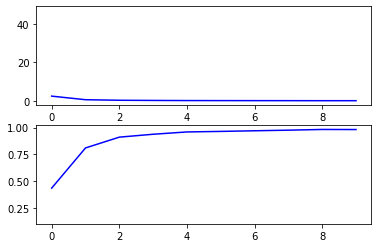

In [ ]:
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model_alex.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_alex.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model_alex.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_alex.history.history['val_accuracy'],color='r',label='Validation Accuracy')

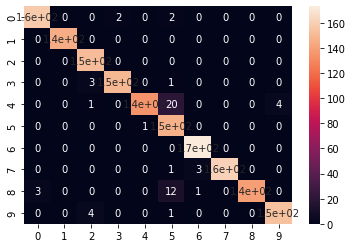

In [ ]:
#Making prediction
import seaborn as sns

y_pred3=model_alex.predict(x_test)
y_true=np.argmax(y_test,axis=1)

y_pred3 = np.argmax(y_pred3, axis=1)

c = []

for i in range(len(y_pred3)):
    c.append(np.array([y_pred3[i]]))
c = np.array(c)

c = to_categorical(c)

y_pred3 = c

#Defining function for confusion matrix plot

np.set_printoptions(precision=2)

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred3.argmax(axis=1))

# class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# # Plotting non-normalized confusion matrix
# # plot_confusion_matrix(y_true, y_pred3, classes=class_names, title='Non-Normalized ResNet50 Confusion Matrix')
sns.heatmap(confusion_mtx, annot = True)

In [ ]:
from sklearn.metrics import accuracy_score
alex_acc = accuracy_score(y_test, y_pred3)
print('Accuracy Score of ResNet50 = ', alex_acc)

Accuracy Score of ResNet50 =  0.9624920534011443
